## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

## After I get calibration coefficients 

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## And test it

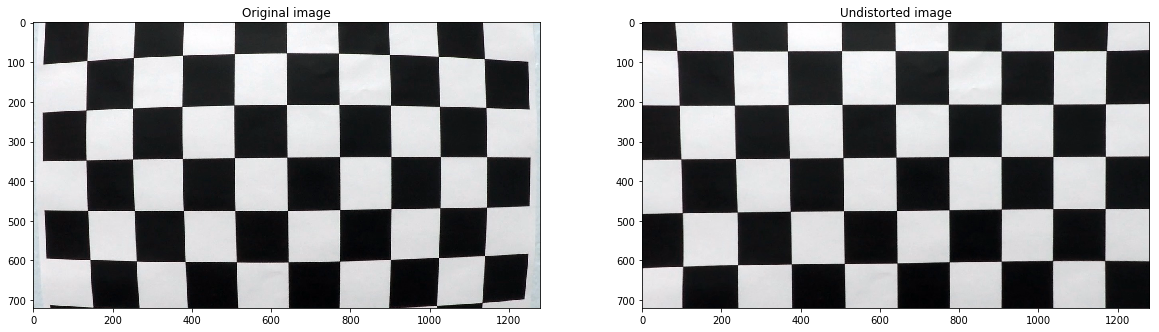

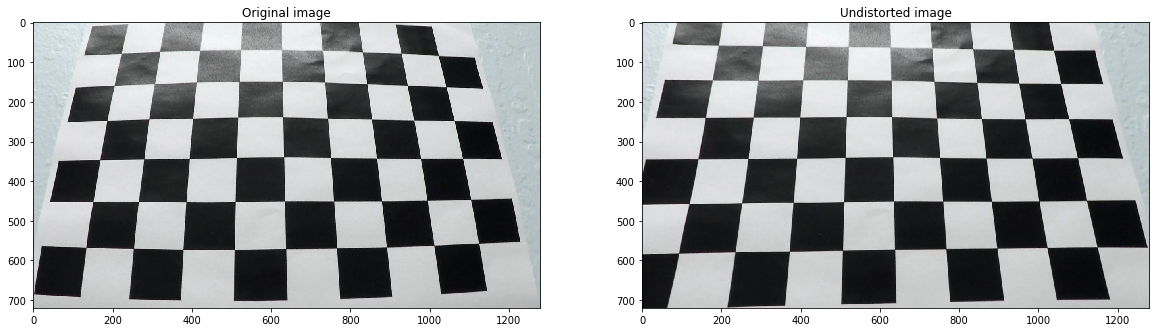

In [3]:
%matplotlib inline
img_test = cv2.imread('camera_cal/calibration1.jpg')
img_cal = cv2.undistort(img_test, mtx, dist, None, mtx)
plt.figure (figsize=(20,40))
plt.subplot(121)
plt.title('Original image')
plt.imshow(img_test)
plt.subplot(122)
plt.title('Undistorted image')
plt.imshow(img_cal)
plt.show()

img_test = cv2.imread('camera_cal/calibration3.jpg')
img_cal = cv2.undistort(img_test, mtx, dist, None, mtx)
plt.figure (figsize=(20,40))
plt.subplot(121)
plt.title('Original image')
plt.imshow(img_test)
plt.subplot(122)
plt.title('Undistorted image')
plt.imshow(img_cal)
plt.show()

## Calibration is applied to the test images

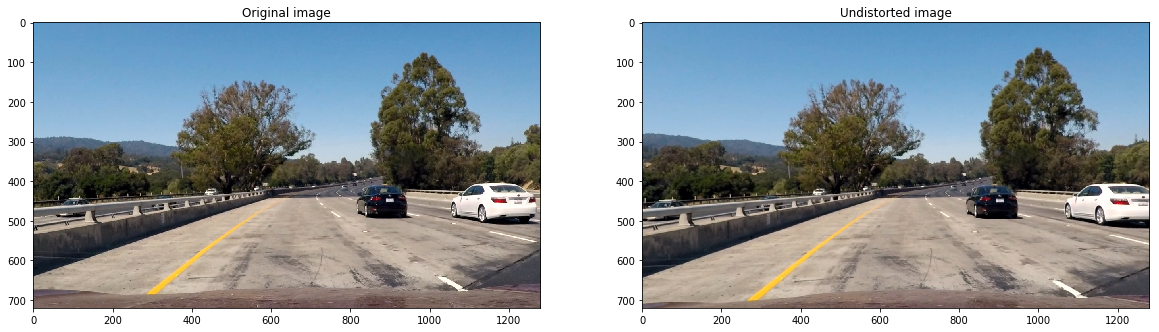

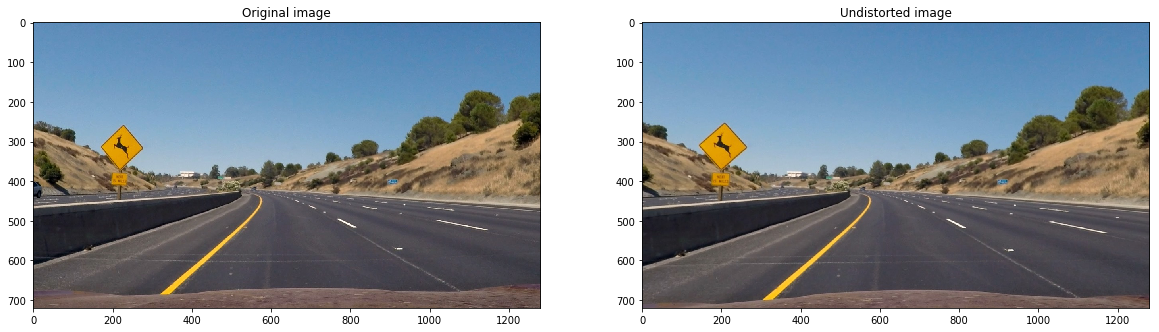

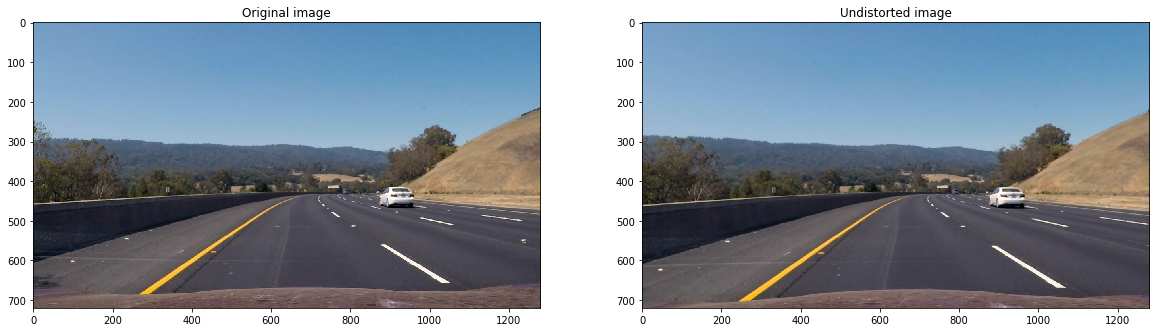

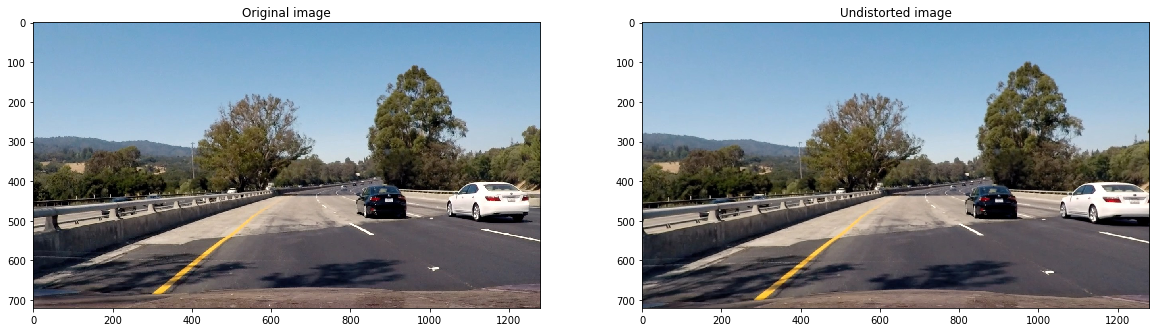

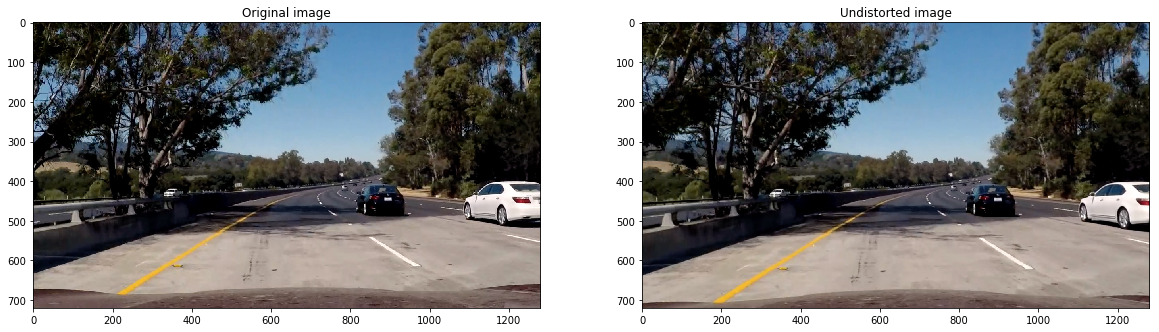

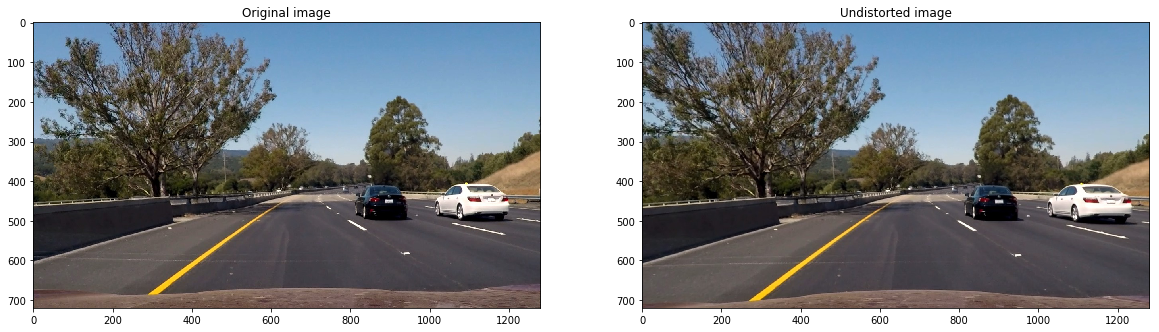

In [4]:
# Shows Calibration of all test images
images_test = glob.glob('test_images/test*.jpg')
for fname in images_test:
    img = cv2.imread(fname)
    img_cal = cv2.undistort(img, mtx, dist, None, mtx)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_cal = cv2.cvtColor(img_cal, cv2.COLOR_BGR2RGB)
    plt.figure (figsize=(20,60))
    plt.subplot(121)
    plt.title('Original image')
    plt.imshow(img)
    plt.subplot(122)
    plt.title('Undistorted image')
    plt.imshow(img_cal)
    plt.show()


## Color Transforms and Gradients

In [5]:
# Defines a function to convert to 1 channel
def to_one_channel (img):
    if (img.ndim > 2):
        out = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        out = img
    return out

# Defines a function to apply sobel threshold to x and y
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = to_one_channel(img)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Defines a function to apply magnitude threshold to an image for a given range and Sobel kernel
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale - one channel
    gray = to_one_channel(img)
    plt.imshow(gray)
    plt.show()
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Defines a function to apply image threshold to an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = to_one_channel(img)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Defines a function to combine different image thresholding methods to an image
def process_thresholding (img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    img_S = hls[:,:,2]
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    sxbinary = abs_sobel_thresh(img_gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(img_S)
    s_binary[(img_S >= s_thresh_min) & (img_S <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary, sxbinary, s_binary, color_binary, img_gray, img_S

## Show transforms and gradients

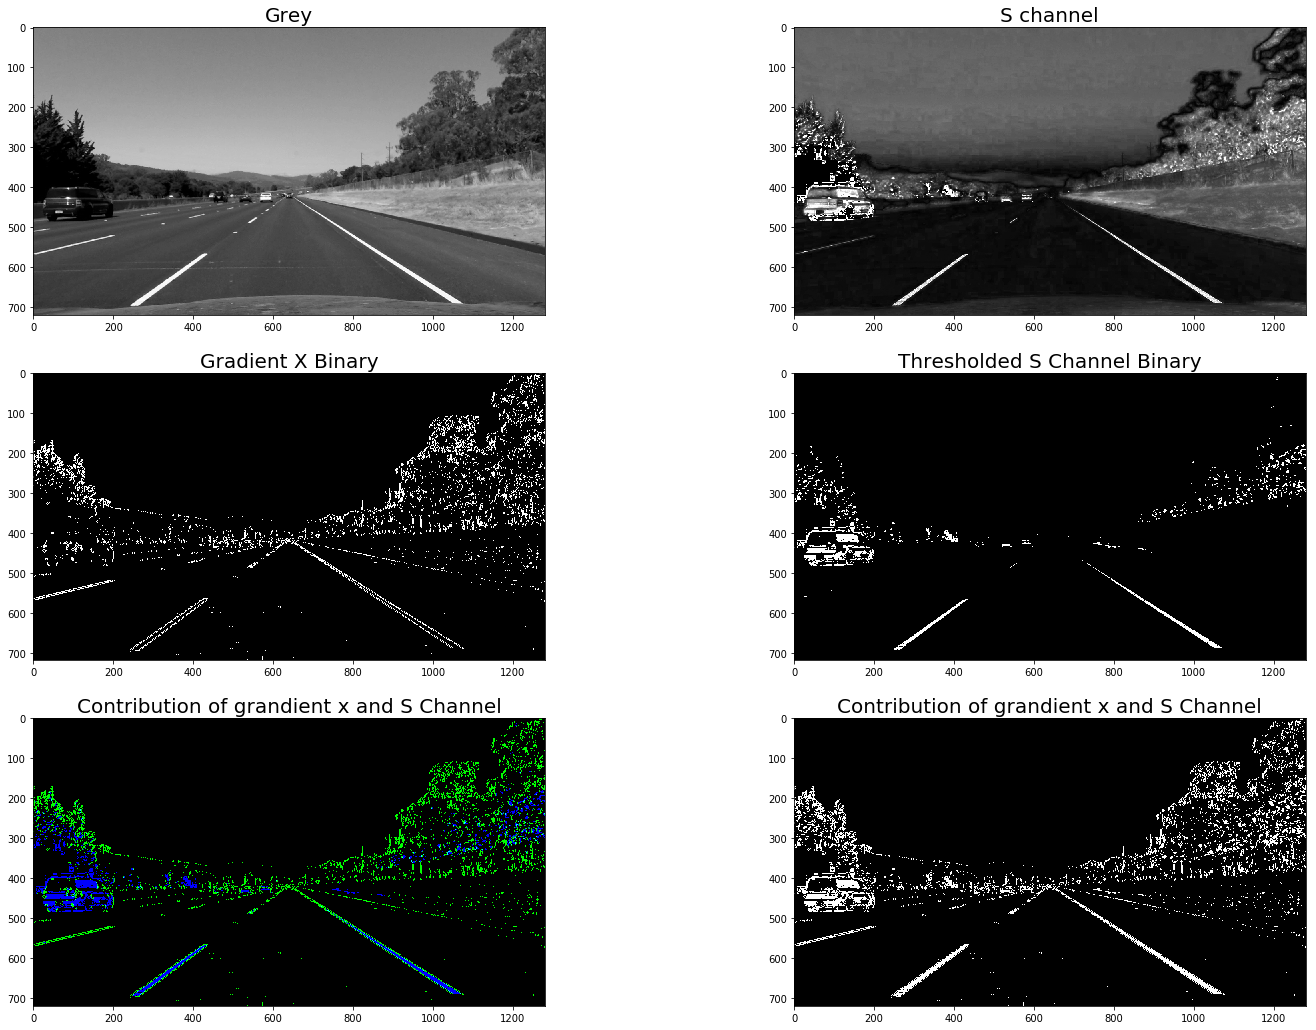

In [6]:
# Shows the differnt thresholding methods and the final result combining them.
img = mpimg.imread('test_images/straight_lines2.jpg')
img_cal = cv2.undistort(img, mtx, dist, None, mtx)
combined_binary, sxbinary, s_binary, color_binary, img_gray, img_S = process_thresholding (img_cal)

# Plot the result
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(25, 18))
#f.tight_layout()
fsize = 20
ax1.imshow(img_gray, cmap='gray')
ax1.set_title('Grey', fontsize=fsize)
ax2.imshow(img_S, cmap='gray')
ax2.set_title('S channel', fontsize=fsize)
ax3.imshow(sxbinary, cmap='gray')
ax3.set_title('Gradient X Binary', fontsize=fsize)
ax4.imshow(s_binary, cmap='gray')
ax4.set_title('Thresholded S Channel Binary', fontsize=fsize)
ax5.imshow(color_binary, cmap='gray')
ax5.set_title('Contribution of grandient x and S Channel', fontsize=fsize)
ax6.imshow(combined_binary, cmap='gray')
ax6.set_title('Contribution of grandient x and S Channel', fontsize=fsize)

plt.show()


## Perspective transform

In [7]:
from operator import add

# Defines a function to return a masked image for the given region of interest.
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        ignore_mask_color = (255,0,0) #red
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.polylines(img, np.int32([vertices]),1, ignore_mask_color,2)
    
    #returning the image only where mask pixels are nonzero
    #masked_image = cv2.bitwise_and(img, mask)
    return img

# Defines a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def warper(img, src_vertices, dst_vertices):
    # Define image shape
    image_shape = img.shape
    src = np.float32(src_vertices)
    dst = np.float32(dst_vertices)
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    return warped, M, Minv

print("corner_unwarp function is created")

corner_unwarp function is created


## Show Perspective transform

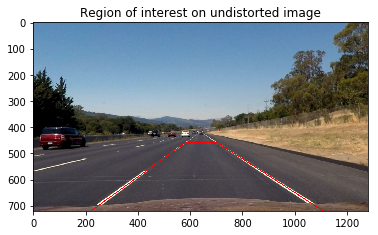

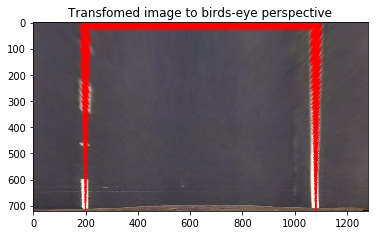

In [8]:
# Transforms the perspective from a test image to birds-eye view
# Parameters set to match lines in vertical colums corresponding to
# 200pix (left) and 1080pix (right)
img_test = mpimg.imread('test_images/straight_lines2.jpg')
img_cal = cv2.undistort(img_test, mtx, dist, None, mtx)
combined_binary = process_thresholding (img_cal)[0]
# Define the region
region_interest_vertices =  np.array([[580,460],[705,460],[1110,720],[220,720]])
# For destination points, I'm choosing: x-> 200, 1080  y-> 0, 720
region_destination_vertices =  np.array([[200, 0], [1080, 0], [1080, 720], [200, 720]])
img_masked = region_of_interest (img_cal,region_interest_vertices)
# img_masked = region_of_interest(img_pth, region_interest_vertices)
img_warped, M, Minv = warper (img_cal, region_interest_vertices,region_destination_vertices)
plt.imshow(img_masked)
plt.title('Region of interest on undistorted image')
plt.show()
plt.imshow(img_warped, cmap='gray')
plt.title ('Transfomed image to birds-eye perspective')
plt.show()

binary_warped, M, Minv = warper (combined_binary,region_interest_vertices,region_destination_vertices)
plt.imshow(binary_warped, cmap='gray')
plt.title ('Final binary transformed image')
plt.show()

## Find lines

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Class Line that contains all the vector points that defines it and the ones
# that had been used to find it, as well as the fitting polynomial.
# It also includes curvature radius and distance offset to the centered position.
class Line():
    # Creates a class Line and initilize a circular buffer for a window size.
    def __init__(self, window):
        # size of the window (number of lines)
        self.nfits = window
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_fitx = None 
        # y points for all recent_fitx
        self.y_points = None 
        #polynomial coeficients of the last n fits of the line
        self.recent_fit = None 
        #average x values of the fitted line over the last n iterations
        self.best_fitx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None  
        #radius of curvature of the line in m
        self.radius_of_curvature = None 
        #radius of curvature of the line in m over the last n iterations
        self.best_radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #distance in meters of vehicle center from the line over the last n iterations
        self.best_line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.zeros(3) 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    # Defines a method to add a new line to the circular buffer    
    def add_line(self, allx, ally, fit, fitx, y_points, curve_rad, line_dist, line_detected):
        self.allx = allx
        self.ally = ally
        fit = fit.reshape (1,fit.shape[0])
        fitx = fitx.reshape (1,fitx.shape[0])
        curve_rad = np.array([curve_rad])
        line_dist = np.array ([line_dist])
        self.y_points = y_points 
        self.detected = line_detected
        if (self.recent_fit == None):
            self.recent_fitx = fitx
            self.recent_fit = fit
            self.radius_of_curvature = curve_rad
            self.line_base_pos = line_dist
        else:
            if(self.recent_fit.shape[0] < self.nfits):
                self.recent_fitx = np.append (self.recent_fitx, fitx , axis=0)
                self.recent_fit = np.append (self.recent_fit, fit , axis=0)
                self.radius_of_curvature = np.append (self.radius_of_curvature, curve_rad)
                self.line_base_pos = np.append (self.line_base_pos, line_dist)
            else:
                self.recent_fitx = np.roll (self.recent_fitx, -1, axis=0)
                self.recent_fitx[-1] = fitx
                self.recent_fit = np.roll (self.recent_fit, -1, axis=0)
                self.recent_fit[-1] = fit
                self.radius_of_curvature = np.roll (self.radius_of_curvature, -1, axis=0)
                self.radius_of_curvature[-1] = curve_rad
                self.line_base_pos = np.roll ( self.line_base_pos, -1, axis=0)
                self.line_base_pos[-1] = line_dist
        self.best_fitx = np.mean (self.recent_fitx, axis=0)
        self.best_fit = np.mean (self.recent_fit, axis=0)
        self.best_radius_of_curvature = np.mean (self.radius_of_curvature, axis=0)
        self.best_radius_of_curvature = np.mean (self.radius_of_curvature, axis=0)
        self.best_line_base_pos = np.mean (self.line_base_pos, axis=0)
        self.current_fit = self.recent_fit[-1]
        self.line_base_pos = line_dist
        if (self.recent_fit.shape[0]  > 1):
            self.diffs = self.best_fit [-1] - self.best_fit [-2]
        else:
            self.diffs = 0
# Defines a function to measure the radius of curvature for a given set of x and y points.
def measure_radius_of_curvature(x_values, y_points):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_eval = np.max(y_points)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

# Defines a function to find lines in a binary image and adds left and right
# line to a given left and right line object.Sliding window is used to find the
# first frame afte that, unless there are not enought points to find a valid
# polynomial fit it will be base on region search basis to reduce calculation time.
def find_lines (binary_warped, left_line, right_line, n_min_points):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    num_rows = binary_warped.shape[0]
    num_cols = binary_warped.shape[1]
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
     
    # Sliding window
    if (left_line.detected == False or right_line.detected == False):
        #print('window')
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        
    # Skip sliding window if detected lines in previous frames
    else:
        #print('skip')
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        left_fit = left_line.recent_fit[-1]
        right_fit = right_line.recent_fit[-1]
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  
   
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Min number points condition for a valid polyfit
    if (leftx.shape[0] < n_min_points):
        left_line_detected = False
    else:
        left_line_detected = True
    
    if (rightx.shape[0]  < n_min_points):
        right_line_detected = False
    else:
        right_line_detected = True
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    
    # Calculate line distance to the reference columns
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_line_dist =  (200 - left_fitx[0])  * xm_per_pix
    right_line_dist = (1080 - right_fitx[0]) * xm_per_pix
  
     # Calculate radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_fitx, ploty)
    right_curve_rad = measure_radius_of_curvature(right_fitx, ploty)
    
    # Add to Left line to Line object
    left_line.add_line (leftx, lefty, left_fit, left_fitx, ploty, left_curve_rad, left_line_dist, left_line_detected)
    # Add to Left line to Line object
    right_line.add_line (rightx, righty, right_fit, right_fitx, ploty, right_curve_rad, right_line_dist, right_line_detected)

    return left_line, right_line

# Defines a fucntion to plot both lines on a given image
def plot_lines (out_img, left_line, right_line):
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]
    plt.figure (figsize=(10,10))
    plt.imshow(out_img)
    plt.plot(left_line.recent_fitx[-1], left_line.y_points, color='yellow')
    plt.plot(right_line.recent_fitx[-1], right_line.y_points, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
# Defines a function to plot the calculated lane on a given image  
def overlay_lane (img, Minv, left_line, right_line):
    img_size = (img.shape[1], img.shape[0])
    nrows = img.shape[0]
    out_img = np.zeros_like(img).astype(np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_line.best_fitx, left_line.y_points]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.best_fitx,right_line.y_points])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(out_img, Minv, img_size)
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, unwarp, .3, 0)
    
    # Overlay curvature, offset and find_lines mode
    average_curve_rad = (left_line.best_radius_of_curvature + right_line.best_radius_of_curvature)/2
    center_offset = (left_line.best_line_base_pos + right_line.best_line_base_pos)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    offset_string = "Center offset: %.2f m" % center_offset
    #mode_string = "Skip Window Search: " + str(left_line.detected) + " / " + str(right_line.detected) 
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

    

## Pipeline

In [10]:
# Process the image. Steps done are:
# 1. Undistorted image with camera calibration parameteres
# 2. Apply thresholding to the image to optimize lines contrast.
# 3. Transform the image perspetive to bird-eye view
# 4. Find lines and store them in a circular buffer
# 5. Overlay calculated lane on distorted image
def process_image (img):
    global left_line 
    global right_line
    # Undistort image with camera calibration parameters
    img_cal = cv2.undistort(img, mtx, dist, None, mtx)
    # Apply thresholding to the image to optimize lines contrast.
    combined_binary = process_thresholding (img_cal)[0]
    # Define the region of interest
    region_interest_vertices =  np.array([[580,460],[705,460],[1110,720],[220,720]])
    # For destination points, I'm choosing: x-> 200, 1080  y-> 0, 720
    region_destination_vertices =  np.array([[200, 0], [1080, 0], [1080, 720], [200, 720]])
    # Transform the image perspetive to bird-eye view
    binary_warped, M, Minv = warper (combined_binary,region_interest_vertices,region_destination_vertices)
    num_rows = binary_warped.shape[0]
    # Find lines
    left_line, right_line = find_lines (binary_warped, left_line, right_line, 1000)
    # Overlay calculated lane on distorted image
    lane_img =  overlay_lane (img_cal, Minv, left_line, right_line)    
    return lane_img

 ## Show line finding process

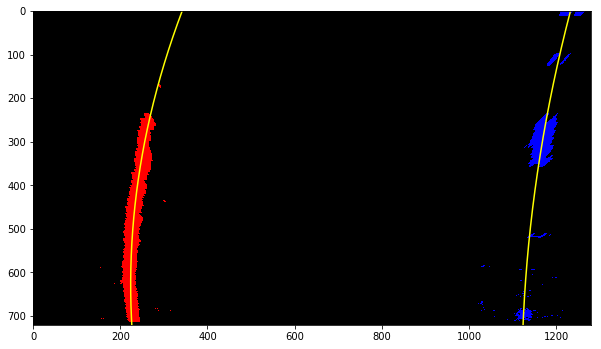

In [11]:
img1 = mpimg.imread('test_images/test1.jpg')
left_line = Line(20)
right_line = Line(20)
lane_img=process_image(img1)
out_img = np.zeros_like (img1).astype(np.uint8)
lines_img = plot_lines (out_img, left_line, right_line)

## Show final result on a test image

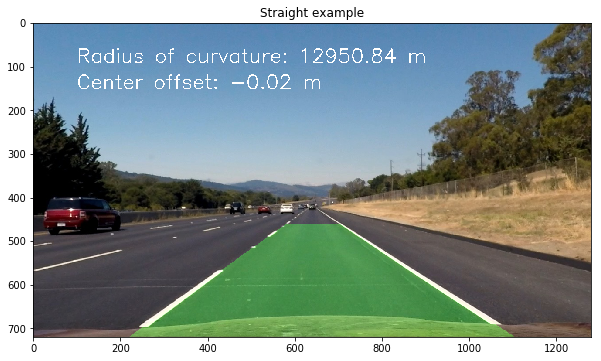

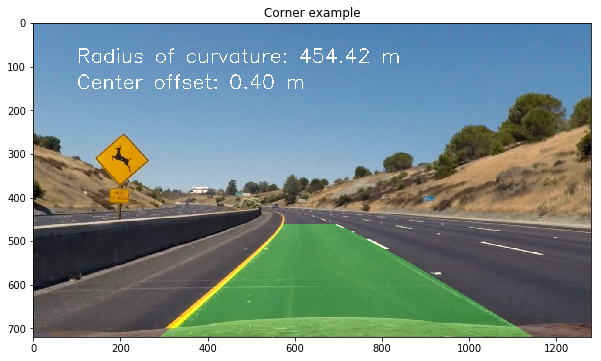

In [12]:
img1 = mpimg.imread('test_images/straight_lines2.jpg')
left_line = Line(20)
right_line = Line(20)
lane_img=process_image(img1)
plt.figure (figsize=(10,10))
plt.title ('Straight example')
plt.imshow(lane_img)
plt.show()

img2 = mpimg.imread('test_images/test2.jpg')
left_line = Line(20)
right_line = Line(20)
lane_img=process_image(img2)
plt.figure (figsize=(10,10))
plt.title ('Corner example')
plt.imshow(lane_img)
plt.show()

## Process Video

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_videos/project_video.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(0,2)
left_line = Line(20)
right_line = Line(20)
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:47<00:00,  7.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 2min 48s
